In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="1"

import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    tf.config.experimental.set_virtual_device_configuration(
        gpus[0],[tf.config.experimental.VirtualDeviceConfiguration(memory_limit=5120)])
  except RuntimeError as e:
    print(e)

In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, Dense, Input, Flatten,\
Conv2DTranspose, BatchNormalization, LeakyReLU, Reshape, MaxPooling2D, concatenate, InputLayer, Lambda
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.datasets import cifar10
import tensorflow.keras.backend as K
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
import numpy as np
import matplotlib.pyplot as plt
import plotly
import plotly.express as px

In [3]:
# input image dimensions
img_rows, img_cols = 32, 32
# Load CIFAR-10 dataset-
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

In [4]:
if tf.keras.backend.image_data_format() == 'channels_first':
    X_train = X_train.reshape(X_train.shape[0], 1, img_rows, img_cols)
    X_test = X_test.reshape(X_test.shape[0], 1, img_rows, img_cols)
    input_shape = (3, img_rows, img_cols)
else:
    X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, 3)
    X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, 3)
    input_shape = (img_rows, img_cols, 3)


In [5]:
# Specify hyper-parameters-
batch_size = 64
num_classes = 10
num_epochs = 50

In [6]:
# Convert datasets to floating point types-
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

# Normalize the training and testing datasets-
X_train /= 255.0
X_test /= 255.0



# X_train, X_test = X_train.reshape(X_train.shape[0], -1), X_test.reshape(X_test.shape[0], -1)
# Create TF datasets-


print("\nDimensions of training and testing sets are:")
print(f"X_train.shape: {X_train.shape} & X_test.shape: {X_test.shape}")


Dimensions of training and testing sets are:
X_train.shape: (50000, 32, 32, 3) & X_test.shape: (10000, 32, 32, 3)


In [7]:
y_train, y_test = to_categorical(y_train), to_categorical(y_test)
print(f"y_train.shape: {y_train.shape} & y_test.shape: {y_test.shape}")

train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train) ).shuffle(50000).batch(batch_size = batch_size)
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test)).shuffle(10000).batch(batch_size = batch_size)

y_train.shape: (50000, 10) & y_test.shape: (10000, 10)


In [8]:
class ConvBlock(Model):
    def __init__(
        self, num_filters,
        kernel_size, stride_length,
        pooling_size, pooling_stride,
        padding_type = 'same'
    ):
        super(ConvBlock, self).__init__()
        
        self.conv1 = Conv2D(
            filters = num_filters, kernel_size = kernel_size,
            strides = stride_length, padding = padding_type,
            activation = None, use_bias = False,
        )
        self.bn = BatchNormalization(
            axis = -1, momentum = 0.99,
            epsilon = 0.001
            )
        
        self.conv2 = Conv2D(
            filters = num_filters, kernel_size = kernel_size,
            strides = stride_length, padding = padding_type,
            activation = None, use_bias = False
        )
        self.bn2 = BatchNormalization(
            axis = -1, momentum = 0.99,
            epsilon = 0.001
            )
        
        self.pool = MaxPooling2D(
            pool_size = pooling_size,
            strides = pooling_stride
        )
        
    
    def call(self, x):
        x = tf.keras.activations.relu(self.bn(self.conv1(x)))
        x = tf.keras.activations.relu(self.bn2(self.conv2(x)))
        x = self.pool(x)
        
        return x

In [9]:
class Conv6_Encoder(Model):
    def __init__(self, latent_dim = 10):
        super(Conv6_Encoder, self).__init__()

        self.latent_dim = latent_dim
        
        self.conv_block1 = ConvBlock(
            num_filters = 64, kernel_size = 3,
            stride_length = 1, pooling_size = 2,
            pooling_stride = 2, padding_type = 'valid'
            )

        self.conv_block2 = ConvBlock(
            num_filters = 128, kernel_size = 3,
            stride_length = 1, pooling_size = 2,
            pooling_stride = 2, padding_type = 'valid'
            )
        
        self.conv_block3 = ConvBlock(
            num_filters = 256, kernel_size = 3,
            stride_length = 1, pooling_size = 2,
            pooling_stride = 2, padding_type = 'same'
            )

        self.flatten = Flatten()
        
        self.output_layer = Dense(
            units = self.latent_dim, activation = None
            )
        self.bn = BatchNormalization(
            axis = -1, momentum = 0.99,
            epsilon = 0.001
            )
        
    
    def call(self, x):
        x1 = x[0]
        x2 = x[1]
        o = self.conv_block1(x1)
        o = self.conv_block2(o)
        o = self.conv_block3(o)
#         res_shape = x.shape
        o = self.flatten(o)
        
        o = K.concatenate([o,x2], axis=-1)
        o = tf.keras.activations.relu(self.bn(self.output_layer(o)))
        return o, x2
    
    def model(self):
        '''
        Overrides 'model()' call.
        Output shape is not well-defined when using sub-classing. As a
        workaround, this method is implemeted.
        '''
        x1 = Input(shape = (32,32,3))
        x2 = Input(shape = (10,))
        return Model(inputs = [x1,x2], outputs = self.call([x1,x2]))
    
    def shape_computation(self, x):
        print(f"Input shape: {x.shape}")
        x = self.conv_block1(x)
        print(f"conv_block1.shape: {x.shape}")
        x = self.conv_block2(x)
        print(f"conv_block2.shape: {x.shape}")
        x = self.conv_block3(x)
        print(f"conv_block3.shape: {x.shape}")
        x = self.flatten(x)
        print(f"flattened shape: {x.shape}")
        x = tf.keras.activations.relu(self.bn(self.output_layer(x)))
        print(f"Encoder output shape: {x.shape}")
        '''
        Input shape: (64, 32, 32, 3)
        conv_block1.shape: (64, 14, 14, 64)
        conv_block2.shape: (64, 5, 5, 128)
        conv_block3.shape: (64, 2, 2, 256)
        flattened shape: (64, 1024)
        Encoder output shape: (64, 100)
        '''
        
        return None

In [10]:
class Conv6_Decoder(Model):
    def __init__(self, latent_dim = 10):
        super(Conv6_Decoder, self).__init__()

        self.latent_dim = latent_dim
#         self.inp_layer = InputLayer(input_shape = self.latent_dim+10)
        
        print('In decoder')
        self.dense0 = Dense(
            units = self.latent_dim+10, activation = None
            )
        self.bn0 = BatchNormalization(
            axis = -1, momentum = 0.99,
            epsilon = 0.001
            )
        
        self.dense = Dense(
            units = 1024, activation = None
        )
        self.bn = BatchNormalization(
            axis = -1, momentum = 0.99,
            epsilon = 0.001
            )
        
        self.dense2 = Dense(
            units = 4 * 4 * 256, activation = None
        )
        self.bn2 = BatchNormalization(
            axis = -1, momentum = 0.99,
            epsilon = 0.001
            )
        
        self.reshape = Reshape((4, 4, 256))
        
        self.conv_transpose_layer1 = Conv2DTranspose(
            filters = 256, kernel_size = 3,
            strides = 2, padding = 'same',
            activation = None
            )
        self.bn3 = BatchNormalization(
            axis = -1, momentum = 0.99,
            epsilon = 0.001
            )
       
        self.conv_transpose_layer2 = Conv2DTranspose(
            filters = 256, kernel_size = 3,
            strides = 1, padding = 'same',
            activation = None
            )
        
        self.bn4 = BatchNormalization(
            axis = -1, momentum = 0.99,
            epsilon = 0.001
            )
        
        self.conv_transpose_layer3 =  Conv2DTranspose(
            filters = 128, kernel_size = 3,
            strides = 2, padding = 'same',
            activation = None
            )
        self.bn5 = BatchNormalization(
            axis = -1, momentum = 0.99,
            epsilon = 0.001
            )
        
        self.conv_transpose_layer4 = Conv2DTranspose(
            filters = 128, kernel_size = 3,
            strides = 1, padding = 'same',
            activation = None
            )
        
        self.bn6 = BatchNormalization(
            axis = -1, momentum = 0.99,
            epsilon = 0.001
            )

        self.conv_transpose_layer5 = Conv2DTranspose(
            filters = 64, kernel_size = 3,
            strides = 2, padding = 'same',
            activation = None
            )
        self.bn7 = BatchNormalization(
            axis = -1, momentum = 0.99,
            epsilon = 0.001
            )
       
        self.conv_transpose_layer6 = Conv2DTranspose(
            filters = 64, kernel_size = 3,
            strides = 1, padding = 'same',
            activation = None
            )
        
        self.bn8 = BatchNormalization(
            axis = -1, momentum = 0.99,
            epsilon = 0.001
            )
        
        self.final_conv_layer = Conv2DTranspose(
            filters = 3, kernel_size = 3,
            strides = 1, padding = 'same',
            activation = None
            )
        
    
    def call(self, X):
#         X = self.inp_layer(X)
        x1 = X[0]
        x2 = X[1]
        X = K.concatenate([x1,x2])
        X = tf.keras.activations.relu(self.bn0(self.dense0(X)))
        X = tf.keras.activations.relu(self.bn(self.dense(X)))
        X = tf.keras.activations.relu(self.bn2(self.dense2(X)))
        X = self.reshape(X)
        X = tf.keras.activations.relu(self.bn3(self.conv_transpose_layer1(X)))
        X = tf.keras.activations.relu(self.bn4(self.conv_transpose_layer2(X)))
        X = tf.keras.activations.relu(self.bn5(self.conv_transpose_layer3(X)))
        X = tf.keras.activations.relu(self.bn6(self.conv_transpose_layer4(X)))
        X = tf.keras.activations.relu(self.bn7(self.conv_transpose_layer5(X)))
        X = tf.keras.activations.relu(self.bn8(self.conv_transpose_layer6(X)))
        # X = tf.keras.activations.sigmoid(self.final_conv_layer(X))
        X = self.final_conv_layer(X)

        return X
        
    def model(self):
        '''
        Overrides 'model()' call.
        Output shape is not well-defined when using sub-classing. As a
        workaround, this method is implemeted.
        '''
        x1 = Input(shape = (100))
        x2 = Input(shape=(10,))
        return Model(inputs = [x1,x2], outputs = self.call([x1,x2]))
    
    def shape_computation(self, x):
        print(f"Input shape: {x.shape}")
        x = tf.nn.relu(self.bn0(self.dense0(x)))
        print(f"first dense layer shape: {x.shape}")
        x = tf.nn.relu(self.bn(self.dense(x)))
        print(f"second dense layer shape: {x.shape}")
        x = tf.nn.relu(self.bn2(self.dense2(x)))
        print(f"third dense layer shape: {x.shape}")
        x = self.reshape(x)
        print(f"reshape: {x.shape}")
        x = tf.nn.relu(self.bn3(self.conv_transpose_layer1(x)))
        print(f"conv transpose layer1 shape: {x.shape}")
        x = tf.nn.relu(self.bn4(self.conv_transpose_layer2(x)))
        print(f"conv transpose layer2 shape: {x.shape}")
        x = tf.nn.relu(self.bn5(self.conv_transpose_layer3(x)))
        print(f"conv transpose layer3 shape: {x.shape}")
        x = tf.nn.relu(self.bn6(self.conv_transpose_layer4(x)))
        print(f"conv transpose layer4 shape: {x.shape}")
        x = tf.nn.relu(self.bn7(self.conv_transpose_layer5(x)))
        print(f"conv transpose layer5 shape: {x.shape}")
        x = tf.nn.relu(self.bn8(self.conv_transpose_layer6(x)))
        print(f"conv transpose layer6 shape: {x.shape}")
        x = self.final_conv_layer(x)
        print(f"Decoder output shape: {x.shape}")
        
        '''
        Input shape: (64, 100)
        first dense layer shape: (64, 100)
        second dense layer shape: (64, 1024)
        third dense layer shape: (64, 4096)
        reshape: (64, 4, 4, 256)
        conv transpose layer1 shape: (64, 8, 8, 256)
        conv transpose layer2 shape: (64, 8, 8, 256)
        conv transpose layer3 shape: (64, 16, 16, 128)
        conv transpose layer4 shape: (64, 16, 16, 128)
        conv transpose layer5 shape: (64, 32, 32, 64)
        conv transpose layer6 shape: (64, 32, 32, 64)
        Decoder output shape: (64, 32, 32, 3)
        '''
        
        return None
        

In [11]:
class Sampling(tf.keras.layers.Layer):
    """
    Create a sampling layer.
    Uses (mu, log_var) to sample latent vector 'z'.
    """
    def call(self, mu, log_var):
    # def call(self, inputs):
        # z_mean, z_log_var = inputs

        # Get batch size-
        batch = tf.shape(mu)[0]

        # Get latent space dimensionality-
        dim = tf.shape(mu)[1]

        # Add stochasticity by sampling from a multivariate standard 
        # Gaussian distribution-
        epsilon = tf.keras.backend.random_normal(
            shape = (batch, dim), mean = 0.0,
            stddev = 1.0
        )
        z = mu + (tf.exp(0.5 * log_var) * epsilon)
        return z



In [12]:
class VAE(Model):
    def __init__(self, latent_space = 100):
        super(VAE, self).__init__()
        
        self.latent_space = latent_space
        self.encoder = Conv6_Encoder(latent_dim = self.latent_space)
        self.decoder = Conv6_Decoder(latent_dim = self.latent_space)
        
        # Define fully-connected layers for computing mean & log variance-
        self.mu = Dense(units = self.latent_space, activation = None)
        self.log_var = Dense(units = self.latent_space, activation = None)


    def reparameterize(self, mu, logvar):
        # Sample from a multivariate Gaussian distribution.
        # Adds stochasticity or variation-
        eps = tf.random.normal(
            shape = mu.shape, mean = 0.0,
            stddev = 1.0
        )
        return (eps * tf.exp(logvar * 0.5) + mu)
        
    
    def call(self, x):
        latent, label = self.encoder(x)
        # x.shape: (batch_size, 100)
        mu = self.mu(latent)
        log_var = self.log_var(latent)
        # z = self.reparameterize(mu, log_var)
        # z = Sampling()([mu, log_var])
        z = Sampling()(mu, log_var)
        
        
        
        '''
        print(f"mu.shape: {mu.shape}, log_var.shape: {log_var.shape}"
              f" & z.shape: {z.shape}")
        # mu.shape: (batch_size, 100), log_var.shape: (batch_size, 100) & z.shape: (batch_size, 100)
        '''
        x = tf.keras.activations.sigmoid(self.decoder([z, label]))
        return x, mu, log_var, z
    
    
    def model(self):
        '''
        Overrides 'model()' call.
        Output shape is not well-defined when using sub-classing. As a
        workaround, this method is implemeted.
        '''
        x1 = Input(shape = (32,32,3))
        x2 = Input(shape = (10,))
        return Model(inputs = [x1,x2], outputs = self.call([x1,x2]))

In [13]:
# Initialize VAE model-
model = VAE(latent_space = 100)
model.model().summary()


In decoder
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 10)]         0           []                               
                                                                                                  
 conv6__encoder (Conv6_Encoder)  ((None, 100),       1251996     ['input_1[0][0]',                
                                 (None, 10))                      'input_2[0][0]']                
                                                                                                  
 dense_4 (Dense)                (None, 100)          10100       ['conv6__encoder[0

In [14]:
x, mu, log_var, z = model.predict([X_train[0].reshape(1,32,32,3),y_train[0].reshape(1,10)])

In [15]:
z.shape

(1, 100)

In [16]:
# # Get model summary-
# model.decoder.model().summary()

In [17]:
# Define an optimizer-
optimizer = tf.keras.optimizers.Adam(learning_rate = 1e-4)

In [18]:
def compute_loss(data, reconstruction, mu, log_var, alpha = 1):
    
    # Reconstruction loss-
    # recon_loss = tf.keras.losses.mean_squared_error(K.flatten(data), K.flatten(reconstruction))

    recon_loss = tf.reduce_mean(
        tf.reduce_sum(
            tf.keras.losses.binary_crossentropy(data[0], reconstruction), axis=(1, 2)
#             tf.keras.losses.mean_squared_error(data, reconstruction),
#             axis = (1, 2)
            )
        )
    
    # KL-divergence loss-    
    kl_loss = -0.5 * (1 + log_var - tf.square(mu) - tf.exp(log_var))
    kl_loss = tf.reduce_mean(
        tf.reduce_sum(
            kl_loss,
            axis = 1
        )
    )

    total_loss = (recon_loss * alpha) + kl_loss
    
    return total_loss, recon_loss, kl_loss
    

In [19]:
@tf.function
def train_one_step(model, optimizer, data, alpha):
    # Function to perform one step/iteration of training

    with tf.GradientTape() as tape:
        # Make predictions using defined model-
        data_recon, mu, log_var, z = model(data)

        # Compute loss-
        total_loss, recon_loss, kl_loss = compute_loss(
            data = data, reconstruction = data_recon,
            mu = mu, log_var = log_var,
            alpha = alpha
        )
    
    # Compute gradients wrt defined loss and weights and biases-
    grads = tape.gradient(total_loss, model.trainable_variables)
    
    # type(grads)
    # list
    
    # Apply computed gradients to model's weights and biases-
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    
    return total_loss, recon_loss, kl_loss


@tf.function
def test_step(model, optimizer, data, alpha):
    '''
    Function to test model performance
    on testing dataset
    '''
    # Make predictions using defined model-
    data_recon, mu, log_var, z = model(data)
    
    # Compute loss-
    total_loss, recon_loss, kl_loss = compute_loss(
        data = data, reconstruction = data_recon,
        mu = mu, log_var = log_var,
        alpha = alpha
    )
    
    return total_loss, recon_loss, kl_loss

In [20]:
# Specify hyper-parameter for reconstruction loss vs. kl-divergence-
alpha = 10

# Python3 dict to contain training metrics-
training_metrics = {}
val_metrics = {}

In [21]:
for epoch in range(1, num_epochs + 1):
    """
    # Manual early stopping implementation-
    if loc_patience >= patience:
        print("\n'EarlyStopping' called!\n")
        break
    """

    # Epoch train & validation losses-
    train_loss = 0.0
    train_r_loss = 0.0
    train_kl_l = 0.0
    val_loss = 0.0
    val_r_loss = 0.0
    val_kl_l = 0.0
    
    for data in train_dataset:
        train_total_loss, train_recon_loss, train_kl_loss = train_one_step(
            model = model, optimizer = optimizer,
            data = list(data), alpha = alpha
        )
        
        train_loss += train_total_loss.numpy()
        train_r_loss += train_recon_loss.numpy()
        train_kl_l += train_kl_loss.numpy()
    
    for test_data in test_dataset:
        test_total_loss, test_recon_loss, test_kl_loss = test_step(
            model = model, optimizer = optimizer,
            data = test_data, alpha = alpha)
        
        val_loss += test_total_loss.numpy()
        val_r_loss += test_recon_loss.numpy()
        val_kl_l += test_kl_loss.numpy()
    
    # vae_train_loss.append(train_loss)
    # vae_val_loss.append(val_loss)

    training_metrics[epoch] = {
        'total_loss': train_loss, 'recon_loss': train_r_loss,
        'kl_loss': train_kl_l
        }
    
    val_metrics[epoch] = {
        'total_loss': val_loss, 'recon_loss': val_r_loss,
        'kl_loss': val_kl_l
    }

    print(f"epoch = {epoch}; total train loss = {train_loss:.4f},"
    f" train recon loss = {train_r_loss:.4f}, train kl loss = {train_kl_l:.4f};"
    f" total val loss = {val_loss:.4f}, val recon loss = {val_r_loss:.4f} &"
    f" val kl loss = {val_kl_l:.4f}"
    )

epoch = 1; total train loss = 5209249.2661, train recon loss = 518921.3849, train kl loss = 20035.4157; total val loss = 1008841.2646, val recon loss = 100200.4110 & val kl loss = 6837.1572
epoch = 2; total train loss = 4959799.2285, train recon loss = 491856.9262, train kl loss = 41229.9745; total val loss = 990640.4233, val recon loss = 98213.3318 & val kl loss = 8507.1072
epoch = 3; total train loss = 4912212.0869, train recon loss = 486797.2874, train kl loss = 44239.2167; total val loss = 984862.8003, val recon loss = 97561.7520 & val kl loss = 9245.2786
epoch = 4; total train loss = 4877279.6680, train recon loss = 482887.7668, train kl loss = 48401.9971; total val loss = 974981.2461, val recon loss = 96493.5046 & val kl loss = 10046.1989
epoch = 5; total train loss = 4834744.4536, train recon loss = 478232.0659, train kl loss = 52423.7974; total val loss = 970161.3745, val recon loss = 95959.6492 & val kl loss = 10564.8882
epoch = 6; total train loss = 4817282.2744, train recon 

epoch = 45; total train loss = 4647513.5771, train recon loss = 459443.0775, train kl loss = 53082.8037; total val loss = 938737.4810, val recon loss = 92792.1020 & val kl loss = 10816.4598
epoch = 46; total train loss = 4646445.3745, train recon loss = 459332.8193, train kl loss = 53117.1799; total val loss = 939157.9629, val recon loss = 92868.7177 & val kl loss = 10470.7874
epoch = 47; total train loss = 4644772.6558, train recon loss = 459168.3578, train kl loss = 53089.0719; total val loss = 939190.8120, val recon loss = 92842.8959 & val kl loss = 10761.8434
epoch = 48; total train loss = 4644081.4243, train recon loss = 459093.2146, train kl loss = 53149.2711; total val loss = 938647.0156, val recon loss = 92792.4196 & val kl loss = 10722.8170
epoch = 49; total train loss = 4642136.2739, train recon loss = 458897.0489, train kl loss = 53165.7752; total val loss = 939009.2734, val recon loss = 92848.1384 & val kl loss = 10527.8929
epoch = 50; total train loss = 4641462.1099, train

In [22]:
# model.save('vgg_based_250')

In [23]:
X_train.shape

(50000, 32, 32, 3)

In [24]:
x_data = X_test[:2000]
y_data = y_test[:2000]
y_data.shape

(2000, 10)

In [25]:
y_data[10]

array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)

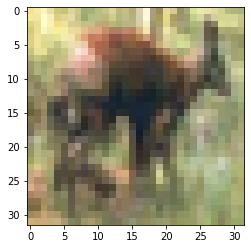

In [26]:
%matplotlib inline
j = 278
x, mu, log_var, z = model.predict([x_data[j].reshape(1,32,32,3), y_data[j].reshape(1,10)])
plt.imshow(x_data[j])

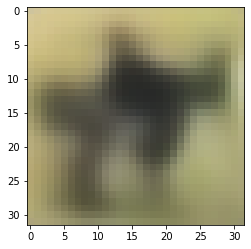

In [27]:
plt.imshow(x[0])

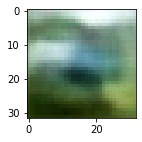

In [28]:
from PIL import Image, ImageEnhance
z_ex = np.random.normal(0, 1, (1,100))
y = y_data[10].reshape(1,10)
z_ex.shape
out = tf.keras.activations.sigmoid(model.decoder([z_ex, y]))
im = tf.keras.preprocessing.image.array_to_img(out[0])
enhancer = ImageEnhance.Sharpness(im)

factor = 5
im_s_1 = enhancer.enhance(factor)

plt.figure(figsize=(2,2))
plt.imshow(im_s_1)

In [29]:
recon = list()
tot = list()
kl = list()
for i in range(50):
    recon.append(training_metrics[i+1]['recon_loss'])
    tot.append(training_metrics[i+1]['total_loss'])
    kl.append(training_metrics[i+1]['kl_loss'])




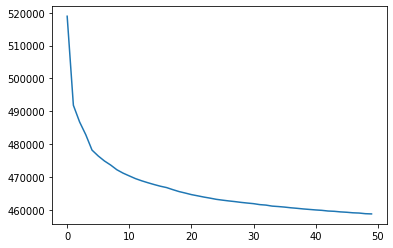

In [30]:
plt.plot(recon)

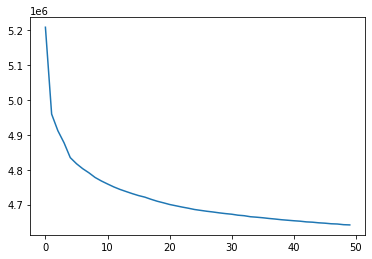

In [31]:
plt.plot(tot)

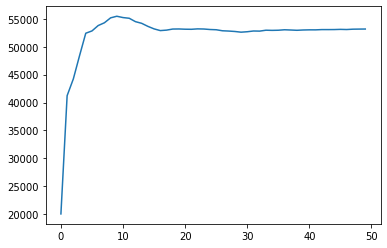

In [32]:
plt.plot(kl)